In [1]:
import numpy as np
import copy
import pandas as pd
import math, re, os
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from pathlib import Path
from functools import partial
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, cross_val_score
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.17.1


In [2]:
# As of now, there seems to be issues with Kaggle TPUs. Hence using GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


# Global variables

In [3]:
DIR_PATH = "/kaggle/input/siim-isic-melanoma-classification/tfrecords/"
TRAIN_PATH = DIR_PATH + "train*.tfrec"
TEST_PATH = DIR_PATH + "test*.tfrec"

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
IMAGE_SIZE = [1024, 1024]
IMAGE_RESIZE = [128, 128]

EPOCHS = 5

TRAIN_ON_FULL_DATA = False
TRAIN_VALID_SPLIT = False
TEST_PREDICT = True

# Load data

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.cast(image, tf.float32) / 255.0   # convnext doesn't need this
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.image.resize(image, IMAGE_RESIZE)
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

Use full data to train an initial model. 

Later lets do train-validation split using jpeg data, since it would be useful to split based on patientid

In [5]:
TRAIN_FILENAMES = tf.io.gfile.glob(TRAIN_PATH) 
TEST_FILENAMES = tf.io.gfile.glob(TEST_PATH)

print('Train TFRecord Files:', len(TRAIN_FILENAMES))
print('Test TFRecord Files:', len(TEST_FILENAMES))

Train TFRecord Files: 16
Test TFRecord Files: 16


In [6]:
# TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
#     tf.io.gfile.glob(TRAIN_PATH),
#     test_size=0.1, random_state=0
# )

# TEST_FILENAMES = tf.io.gfile.glob(TEST_PATH)

# print('Train TFRecord Files:', len(TRAINING_FILENAMES))
# print('Validation TFRecord Files:', len(VALID_FILENAMES))
# print('Test TFRecord Files:', len(TEST_FILENAMES))

# Data Augmentation

In [7]:
def augmentation_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

# Get datasets

In [8]:
def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES, labeled=True)
    dataset = dataset.map(augmentation_pipeline, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


NUM_TRAINING_IMAGES = count_data_items(TRAIN_FILENAMES)
# NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
# print(
#     'Dataset: {} training images, {} validation images, {} unlabeled test images'.format(
#         NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES
#     )
# )
print(
    'Dataset: {} training images, {} unlabeled test images'.format(
        NUM_TRAINING_IMAGES, NUM_TEST_IMAGES
    )
)

Dataset: 33126 training images, 10982 unlabeled test images


In [9]:
train_dataset = get_training_dataset()
# valid_dataset = get_validation_dataset()

In [10]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    image_batch = copy.deepcopy(image_batch)
    image_batch = tf.cast(image_batch, tf.float32) / 255.0
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("Malignant")
        else:
            plt.title("Benign")
        plt.axis("off")

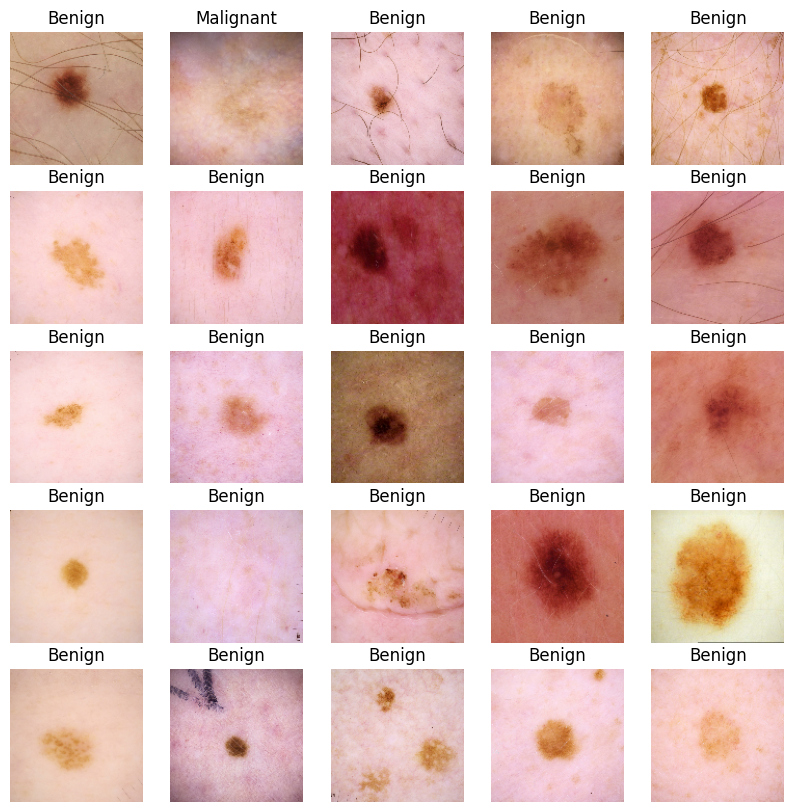

In [11]:
image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

In [12]:
# image_batch, label_batch = next(iter(valid_dataset))
# show_batch(image_batch.numpy(), label_batch.numpy())

Load the train and valid dataset again, since we have iterated over them to show_batch

In [13]:
train_dataset = get_training_dataset()
# valid_dataset = get_validation_dataset()

In [14]:
if TRAIN_ON_FULL_DATA or TRAIN_VALID_SPLIT:

    base_model = keras.applications.EfficientNetV2S(
        include_top=False,
        input_shape=(*IMAGE_RESIZE, 3),
        include_preprocessing=True
    )
    base_model.trainable = False
        
    inputs = keras.Input(shape=(*IMAGE_RESIZE, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.summary(show_trainable=True)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 128, 128, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-s (Functional)       │ (None, 4, 4, 1280)           │    20,331,360 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         1,281 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,332,641 (77.56 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
if TRAIN_ON_FULL_DATA or TRAIN_VALID_SPLIT:

    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-5, 
        decay_steps=10000, 
        decay_rate=0.9)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
        loss='binary_crossentropy',  
        metrics=[keras.metrics.AUC(name='auc')])

In [15]:
if TRAIN_ON_FULL_DATA:
    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
    history = model.fit(train_dataset, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS)

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 156s 409ms/step - auc: 0.4853 - loss: 0.8370
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 101s 393ms/step - auc: 0.5281 - loss: 0.6141
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 103s 398ms/step - auc: 0.5360 - loss: 0.4624
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 101s 391ms/step - auc: 0.5908 - loss: 0.3567
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 102s 395ms/step - auc: 0.5742 - loss: 0.2862


<Axes: >

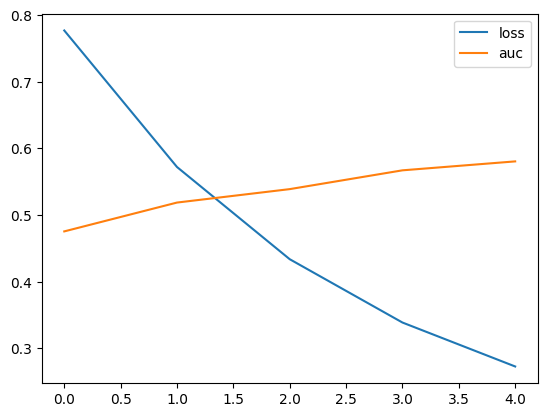

In [18]:
if TRAIN_ON_FULL_DATA:
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'auc']].plot()

In [29]:
if TRAIN_ON_FULL_DATA:
    model.save("effnetv2_s_1.keras")

In [30]:
if TEST_PREDICT:
    model = keras.models.load_model("/kaggle/input/melanoma-classification/tensorflow2/effnetv2_s_1/1/effnetv2_s_1.keras")
    model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 4, 4, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,335,204 (77.57 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 2,563 (10.02 KB)

# Predict on test data

In [33]:
if TEST_PREDICT:
    test_dataset = get_test_dataset(ordered=True)
    test_images = test_dataset.map(lambda image, idnum: image)
    prediction_prob = model.predict(test_images, steps=int(np.ceil(NUM_TEST_IMAGES / BATCH_SIZE)))

    print(prediction_prob)

86/86 ━━━━━━━━━━━━━━━━━━━━ 33s 379ms/step
[[0.21545957]
 [0.19128804]
 [0.17560513]
 ...
 [0.09127545]
 [0.23959264]
 [0.15019166]]


# Create submission file

In [28]:
if TEST_PREDICT:
    image_names = np.array([img_name.numpy().decode("utf-8") 
                            for img, img_name in iter(test_dataset.unbatch())])
    
    submission = pd.DataFrame(dict(image_name=image_names, target=prediction_prob[:, 0]))
    submission = submission.sort_values('image_name') 
    submission.to_csv('submission.csv', index=False)
    !head submission.csv

image_name,target
ISIC_0052060,0.3137431
ISIC_0052349,0.27427974
ISIC_0058510,0.1415045
ISIC_0073313,0.114638664
ISIC_0073502,0.1458663
ISIC_0074618,0.16664283
ISIC_0076801,0.10320034
ISIC_0077586,0.21704945
ISIC_0082004,0.17177851


# References
* https://www.kaggle.com/code/jessemostipak/getting-started-tpus-cassava-leaf-disease
* https://www.kaggle.com/code/amyjang/tensorflow-transfer-learning-melanoma
* https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords
